# Patches

In [49]:
# Loading the dataset function
from dataset_functions import *
from patches_functions import *

In [50]:
# Loading Dataset
dataset_path = r"/home/trishna/HSI_segmentation/PCBVision/PCBDataset/"
#HSI, HSI_general_masks, HSI_monoseg_masks, RGB, RGB_monoseg_masks, RGB_general_masks, PCB_Masks = read_dataset(dataset_path)
HSI, HSI_general_masks, HSI_monoseg_masks, _, _, _, _ = read_dataset(dataset_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 25.56it/s]

Dataset loading is complete.


## Data cleaning

In [51]:
# Clipping values outside [0, 1] range
HSI = clipping_neg_pos(HSI)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:35<00:00,  1.51it/s]


Clipping data is complete. No more negative values.


In [4]:
# Discarding the first 10 bands (noisy)
HSI = slicing(HSI,10)
HSI[0].shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:03<00:00, 14.84it/s]

Skipping first 10 bands
The HS cubes have 214 channels, the first 10 are sliced out.


(272, 499, 214)

In [5]:
# Splitting the Dataset: 33% training - 5% Validation - 56% Testing
# Training set is balanced
training = [1,3,8,11,17,22,23,24,25,32,34,44,45,47,49,50,52,53]
validation = [18, 37, 42] 
testing = [2, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 26, 27, 28, 29, 30, 31, 33, 36, 38, 39, 40, 41, 43, 46, 48, 51]

# Reading the data

In [48]:
# Create training data + augmentation
Training_cubes, Training_masks = Generate_Training_data(training, HSI, HSI_general_masks)

# For Monoseg change HSI_general_masks to HSI_monoseg_masks
# Training_cubes, Training_masks = Generate_Training_data(training, HSI, HSI_monoseg_masks)

# Size check
len(Training_cubes), len(Training_masks)
print(Training_cubes[0].shape)

(272, 499, 214)


In [7]:
# Creating training patches
Training_patches, Training_masks = create_patches(Training_cubes, Training_masks, patch_size=128)
len(Training_patches), len(Training_masks)

(2226, 2226)

In [8]:
# Create validation data
validation_cubes, validation_masks = Generate_Validation_data(validation, HSI, HSI_general_masks)

# For Monoseg change HSI_general_masks to HSI_monoseg_masks
# Training_cubes, Training_masks = Generate_Training_data(training, HSI, HSI_monoseg_masks)

# Size check
len(validation_cubes), len(validation_masks)

(3, 3)

In [9]:
Validation_patches,Validation_masks = create_patches(validation_cubes, validation_masks, patch_size=128)
len(Validation_patches), len(Validation_masks)


(63, 63)

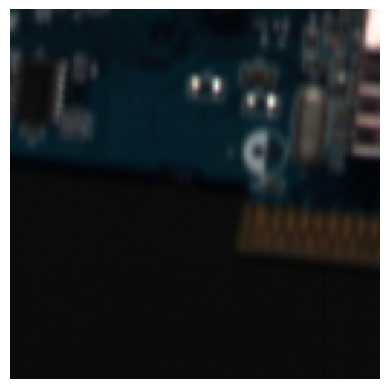

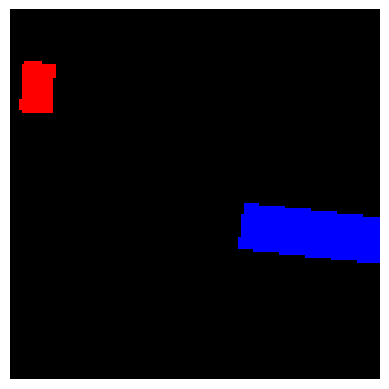

In [10]:
# Training patch visualization
i = 77
plt.imshow(Training_patches[i][:,:,(90,55,32)])
plt.axis('off')
plt.figure()
visualize(Training_masks[i])

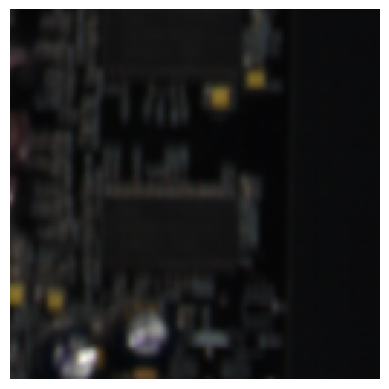

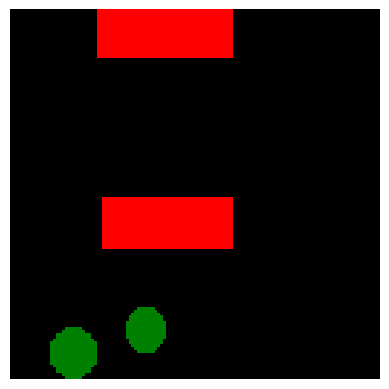

In [11]:
# Validation patch visualization
i = 8
plt.imshow(Validation_patches[i][:,:,(90,55,32)])
plt.axis('off')
plt.figure()
visualize(Validation_masks[i])

In [12]:
# Create test data
Testing_cubes, Testing_masks = Generate_Validation_data(testing, HSI, HSI_general_masks)

# For Monoseg change HSI_general_masks to HSI_monoseg_masks
# Training_cubes, Training_masks = Generate_Training_data(training, HSI, HSI_monoseg_masks)

# Size check
len(Testing_cubes), len(Testing_masks)

Testing_patches,Testing_masks = create_patches(Testing_cubes, Testing_masks, patch_size=128)
len(Testing_patches), len(Testing_masks)

(690, 690)

In [13]:
# Training - validation - testing sets check
len(Training_patches), len(Training_masks), len(Validation_patches), len(Validation_masks), len(Testing_patches), len(Testing_masks)

(2226, 2226, 63, 63, 690, 690)

# Deep Learning Part

In [14]:
# Training - validation - testing sample size check
Training_patches[0].shape, Training_masks[0].shape, Validation_patches[0].shape, Validation_masks[0].shape, Testing_patches[0].shape, Testing_masks[0].shape

((128, 128, 214),
 (128, 128),
 (128, 128, 214),
 (128, 128),
 (128, 128, 214),
 (128, 128))

In [15]:
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, masks):
        # Initialize the dataset with the input images and masks
        self.images = images
        self.masks = masks

    def __len__(self):
        # Return the length of the dataset, which is the number of input images
        return len(self.images)

    def __getitem__(self, index):
        # Retrieve the image and mask corresponding to the given index
        image = self.images[index]
        mask = self.masks[index]

        # Convert the image and mask to torch tensors
        # The `torch.from_numpy()` function converts the numpy arrays to tensors
        # The `.float()` attribute converts the tensors to floating-point format
        # The `torch.as_tensor()` function converts the mask to a long tensor
        image = torch.from_numpy(image.copy()).float()
        mask = torch.from_numpy(mask.copy()).float()
        mask = torch.as_tensor(mask, dtype=torch.long)
        
        return image, mask

In [ ]:
!pip install einops

In [43]:
from models.Unet import UNET
from models.Unet_Attention import AttU_Net
from models.ResUnet import ResUnet
from models.Unet_ScSE import SCSE_AttU_Net
from models.Unet_Dual_Attention import DualAttn_Net
device = set_gpu(0)

# Set up the hyperparameters and configuration
num_classes = 4  # Number of output classes
batch_size = 4 # Batch size for training
learning_rate = 0.000005  # Learning rate for the optimizer
num_epochs = 100  # Number of training epochs
patience = 20  # Number of epochs to wait for improvement before early stopping

# Define class weights to handle class imbalance
class_weights = [0.1, 0.6, 0.95, 0.95]  # Weights for each class
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert weights to tensors and move to device

# Create the U-Net model
#model = UNET(in_channels = 214, out_channels = num_classes) # Specify input and output channels
#model = AttU_Net(img_ch=214,output_ch=num_classes)
#model = ResUnet(channel=214,out_channel=num_classes)
model = SCSE_AttU_Net(img_ch=214,output_ch=num_classes)
#model = DualAttn_Net(img_ch=214,output_ch=num_classes)
#BAND = 214  # Update this to match your input band dimension


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use the class weights in the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer with specified learning rate



# Define training, validation, and testing datasets
train_dataset = CustomDataset(Training_patches, Training_masks)  # Create training dataset from training patches and masks
val_dataset = CustomDataset(Validation_patches, Validation_masks)  # Create validation dataset from validation patches and masks
test_dataset = CustomDataset(Testing_patches, Testing_masks)  # Create testing dataset from testing patches and masks

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)  # Configure training data loader
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=0, pin_memory=True)  # Configure validation data loader
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, pin_memory=True)  # Configure testing data loader

# Specify the path to the pre-trained weights file: Change according to the chosen model !!
path = 'General_Patch_SCSE_AttU_Net.pth'
print(model)

DualAttn_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(214, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=Tr

In [182]:
import time
epochs_without_improvement = 0

# Training loop initialization
best_epoch = 0  # Stores the epoch with the best validation loss so far
best_val_loss = float('inf')  # Stores the minimum validation loss so far

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tic1 = time.time()
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode   
    train_loss = 0.0  # Initialize the training loss
    
    # Iterate over training batches
    for images, masks in train_loader:
        
        # Zero gradients for optimizer
        optimizer.zero_grad()

        # Move the data to GPU
        images = images.to(device)
        masks = masks.to(device)

        # Remove the channel dimension from masks
        masks = torch.squeeze(masks, dim=1)
        # Convert masks to one-hot encodings and match output shape
        masks = torch.nn.functional.one_hot(masks, num_classes)
        
        # Correct the dimension order: (batch, row, col , channel) --> (batch, channel, row, col)
        masks = masks.permute(0, 3,1,2)  # (16, 128, 128, 4) --> (16, 4, 128, 128)
        #images = images.permute(0, 3,1,2)  # (16, 128, 128, 214) --> (16, 214, 128, 128)
        images = images.permute(0, 3,1,2)  # (16, 128, 128, 214) --> (16, 214, 128, 128)
        #images = images.unsqueeze(1) 
        # Masks must be float
        masks = masks.type(torch.FloatTensor).to(device)
    
        # Forward pass others
        outputs = model(images).to(device)
        loss = criterion(outputs, masks)


        # Backpropagation and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        # Accumulate training loss
        train_loss += loss.item()

    # Print the average training loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
   
    val_loss = 0.0  # Initialize the validation loss
    
    # Disable gradient calculation (not needed for validation)
    with torch.no_grad():
        for images, masks in val_loader:
            # Move the data to GPU
            images = images.to(device)
            masks = masks.type(torch.LongTensor)
            masks = masks.to(device)

            # Remove the channel dimension from masks
            masks = torch.squeeze(masks, dim=1)
            
            # Convert masks to one-hot encodings and match output shape
            masks = torch.nn.functional.one_hot(masks, num_classes)
            masks = masks.permute(0, 3, 1, 2)
            # For some reason the type has to be confirmed to float before the needed step, otherwise an error was generated
            masks = masks.type(torch.FloatTensor)

            images = images.permute(0, 3, 1, 2)
           

            # Forward pass for others
            outputs = model(images).to(device)

           
            
            # For some reason moving to the device has to be confirmed, otherwise an error was generated
            # Move masks to the same device as outputs
            masks = masks.to(outputs.device)
            criterion = criterion.to(device)
            
            # Calculate validation loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Print average validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader):.4f}")

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        # Update best validation loss and epoch
        best_val_loss = val_loss
        best_epoch = epoch

        # Reset early stopping counter
        epochs_without_improvement = 0
        
        # Save model weights
        torch.save(model.state_dict(), path)
        print(f"Best Epoch so far [{epoch+1}/{num_epochs}], Best Validation Loss so far: {val_loss / len(val_loader):.4f}")

        # Increment early stopping counter
        epochs_without_improvement += 1
    
    # Trigger early stopping if there are no improvements for `patience` epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in {patience} epochs.")
        break

# Print best epoch and corresponding validation loss
print(f"Best Epoch: {best_epoch + 1}, Best Validation Loss: {best_val_loss / len(val_loader):.4f}")

Epoch [1/100], Train Loss: 0.1322
Epoch [1/100], Validation Loss: 0.1079
Best Epoch so far [1/100], Best Validation Loss so far: 0.1079
Epoch [2/100], Train Loss: 0.0968
Epoch [2/100], Validation Loss: 0.0841
Best Epoch so far [2/100], Best Validation Loss so far: 0.0841
Epoch [3/100], Train Loss: 0.0804
Epoch [3/100], Validation Loss: 0.0735
Best Epoch so far [3/100], Best Validation Loss so far: 0.0735
Epoch [4/100], Train Loss: 0.0690
Epoch [4/100], Validation Loss: 0.0670
Best Epoch so far [4/100], Best Validation Loss so far: 0.0670
Epoch [5/100], Train Loss: 0.0599
Epoch [5/100], Validation Loss: 0.0573
Best Epoch so far [5/100], Best Validation Loss so far: 0.0573
Epoch [6/100], Train Loss: 0.0524
Epoch [6/100], Validation Loss: 0.0518
Best Epoch so far [6/100], Best Validation Loss so far: 0.0518
Epoch [7/100], Train Loss: 0.0457
Epoch [7/100], Validation Loss: 0.0470
Best Epoch so far [7/100], Best Validation Loss so far: 0.0470
Epoch [8/100], Train Loss: 0.0394
Epoch [8/100],

## Training phase for VIT 

In [44]:
path = 'General_Patch_SCSE_AttU_Net.pth'

## Testing phase

In [45]:
import time  # Import the time module

# Load the trained weights
model.load_state_dict(torch.load(path, weights_only=True))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model in evaluation mode: disables certain training-related features
model.eval()

# Initialize lists to store predicted masks and inference times
predicted_masks = []
inference_times = []
# Iterate over the test images and their ground truth masks
for images, masks in test_loader:
        
    # Move the data to GPU
    images = images.to(device)  # Transfer the image data to the specified device
    masks = masks.type(torch.LongTensor)  # Convert the ground truth masks to LongTensor format
    masks = masks.to(device)  # Transfer the ground truth masks to the specified device

    # Remove the channel dimension from masks: Flatten the masks to remove the channel dimension
    masks = torch.squeeze(masks, dim=1)
            
    # To make the masks have same shape and style as the output of the model
    masks = torch.nn.functional.one_hot(masks, num_classes) # Convert the masks to one-hot encodings
    masks = masks.permute(0, 3, 1, 2)  # Transpose the masks to match the expected output shape
    images = images.permute(0, 3, 1, 2)  # Transpose the images to match the expected input shape
    masks = masks.type(torch.FloatTensor)  # Convert the masks to FloatTensor format
    # Measure inference time
    start_time = time.time()  # Record the start time
    
    # Perform inference
    with torch.no_grad():  # Forward pass the images through the model to obtain the predictions
        output = model(images)  # Forward pass the images through the model to obtain the predictions 


    end_time = time.time()  # Record the end time
    inference_time = end_time - start_time  # Calculate the inference time
    inference_times.append(inference_time)  # Append the inference time to the list
    
    # Remove batch dimension
    output = torch.squeeze(output, dim=0)  # (1, 4, 128, 128) --> (4, 128, 128)
    output = torch.nn.functional.softmax(output, dim=0)
    output = torch.argmax(output, dim=0)
    
    # Transfer the output to CPU memory and convert it to a numpy array
    predicted_mask = output.cpu().numpy()  
    
    # Append the predicted mask to the list
    predicted_masks.append(predicted_mask)


# Calculate the average inference time
average_inference_time = sum(inference_times) / len(inference_times)

# Print the average inference time
print(f"Average inference time per batch: {average_inference_time:.4f} seconds")

Average inference time per batch: 0.0045 seconds


In [28]:
# Size & Dimension Checks
len(predicted_masks),len(Testing_masks), predicted_masks[0].shape, Testing_masks[0].shape

(690, 690, (128, 128), (128, 128))

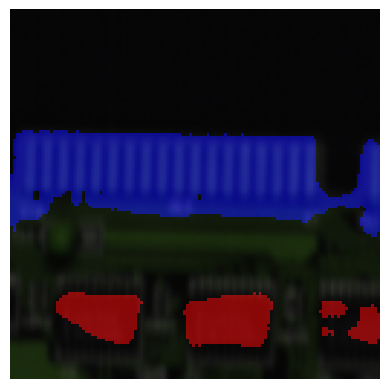

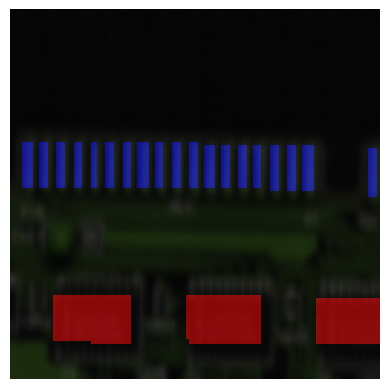

In [188]:
i = 120
#plt.imshow(Testing_patches[i][:,:,(88,57,29)],alpha = 1)
visualize(predicted_masks[i])
plt.axis('off')
plt.imshow(Testing_patches[i][:,:,(44,57,29)],alpha = 0.5)
plt.figure()
visualize(Testing_masks[i])
plt.axis('off')
plt.imshow(Testing_patches[i][:,:,(44,57,29)],alpha = 0.5)



## Evaluation phase

In [30]:
# Convert the list to a numpy array
predicted_masks2 = np.array(predicted_masks)

# Caculate the segmentation metrics
confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class, pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(Testing_masks, predicted_masks2, num_classes)

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix_sum)
print("Pixel Accuracy:")
print(pixel_accuracy)
print("Precision:")
print(precision)
print("Recall:")
print(recall)
print("F1 Score:")
print(f1_score)
print("Intersection over Union (IoU):")
print(iou)
print("Dice Coefficient:")
print(dice_coefficient)
print("Kappa Coefficient:")
print(kappa)


Confusion Matrix:
[[10469055    73115     7309    39065]
 [  352734   289516     1928       37]
 [    8396       71    24184        3]
 [    9535        0        1    30011]]
Pixel Accuracy:
0.9564621192821557
Precision:
[0.96580493 0.79822003 0.72359524 0.43421205]
Recall:
[0.98871526 0.44940897 0.74061371 0.75886919]
F1 Score:
[0.97712582 0.57505435 0.73200557 0.55236833]
Intersection over Union (IoU):
[0.95527469 0.4035623  0.57729399 0.3815669 ]
Dice Coefficient:
[0.97712582 0.57505435 0.73200557 0.55236833]
Kappa Coefficient:
[0.58197201 0.95395233 0.9563415  0.95631596]
